## Data and Package Importing

In [1]:
import sys
sys.path.append('../')
from QC import *
sc.settings.set_figure_params(dpi=80, frameon=False)

### Load data and preprocess

In [2]:
%time s1 = sc.read_h5ad('../data/2771-AS-1-GCCAAT_S1.h5ad') # read in one of the annotated example files

CPU times: user 3.25 s, sys: 560 ms, total: 3.81 s
Wall time: 3.8 s


In [3]:
s1 # see contents of AnnData object

AnnData object with n_obs × n_vars = 8064 × 38459 
    obs: 'ken_filter'

Standard preprocessing to get metadata for barcodes:

In [4]:
# checkpoint raw data for future filtering
s1.raw = s1

In [5]:
%%time
# quick reordering of AnnData object, since our inflection point analysis assumes that libraries are sorted from highest to lowest quality
reorder_adata(s1)

# create new "observations" as percent and mean mito genes
s1.var['mito'] = s1.var_names.str.contains('mt-') # identify mitochondrial genes
s1.obs['mean_mito'] = np.mean(s1[:,s1.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(s1, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var

# rank cells by total counts and save as .obs
s1.obs['ranked_total_counts'] = np.argsort(s1.obs['total_counts'])

CPU times: user 3.04 s, sys: 897 ms, total: 3.94 s
Wall time: 3.94 s


### Thresholding
Let's try employing automated threshold picking from [scikit-image](https://scikit-image.org/docs/dev/api/skimage.filters.html) to determine the cutoff between our __empty__ and __non-empty__ droplets.

In [6]:
from skimage.filters import threshold_li, threshold_otsu # two popular thresholding methods

In [7]:
# use both Otsu's and Li's methods on the log-transformed total counts for each barcode:
thresh_otsu = threshold_otsu(np.array(s1.obs['log1p_total_counts']))
thresh_li = threshold_li(np.array(s1.obs['log1p_total_counts']))

Plot Otsu and Li thresholds on `log1p_total_counts`:

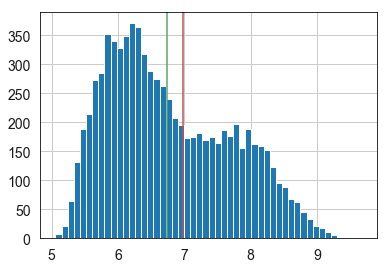

In [8]:
_ = plt.hist(s1.obs['log1p_total_counts'], bins=50)
plt.axvline(thresh_otsu, color='r') # otsu threshold
plt.axvline(thresh_li, color='g') # li threshold

### Find inflection point

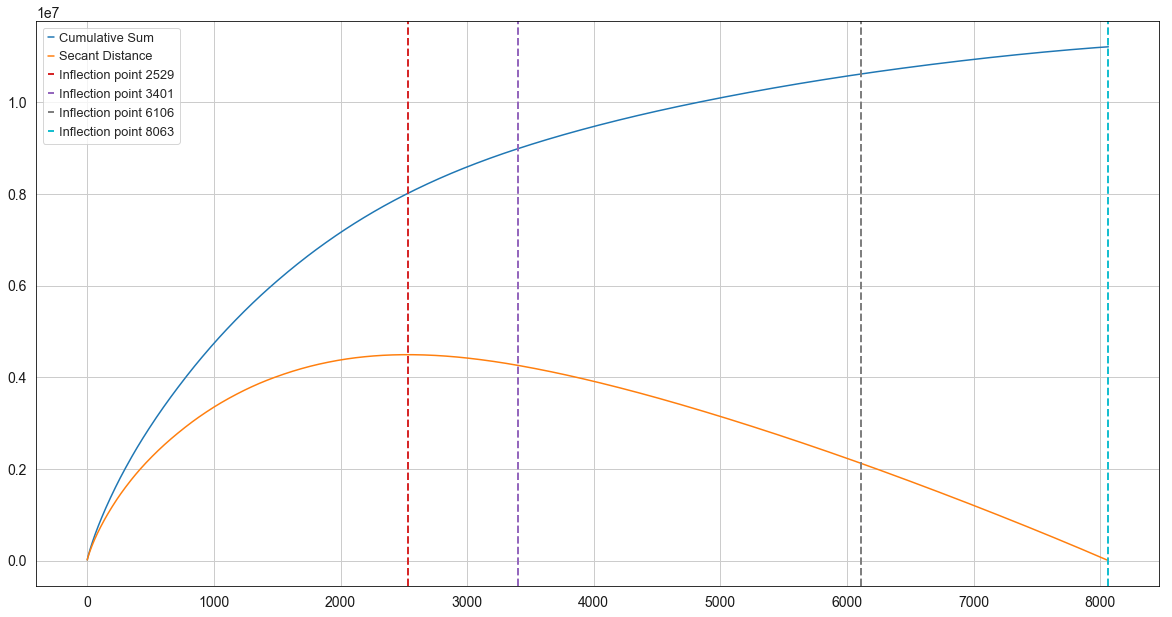

Inflection point at index
bcFJXN    2529
bcFXFE    3401
bcFOEH    6106
bcEBWV    8063
Name: total_counts, dtype: int64 for [0, 20, 70, 100] percentiles of greatest secant distances


{0: 2529, 20: 3401, 70: 6106, 100: 8063}

In [10]:
# inflection_percentiles are percentages of maximum secant distance. we wanna pick one to the right of the maximum
find_inflection(s1, inflection_percentiles = [0,20,70,100], output_prefix='')

The purple cutoff looks pretty good if we were manually filtering the data. Let's see how many total counts and log1p-transformed total counts the cell at that position has:

In [11]:
s1.obs['total_counts'][3401] # see the total counts for the cutoff point

904.0

In [12]:
s1.obs['log1p_total_counts'][3401] # see the log-transformed total counts for the cutoff point; this should be close to otsu or li threshold

6.8079348

So the above number should correspond to a cutoff between the two 'lumps' in our `log1p_total_counts` distribution, and it looks close to our `Otsu` and `Li` thresholds.  
Let's plot it to compare to the automated thresholds from `skimage`:

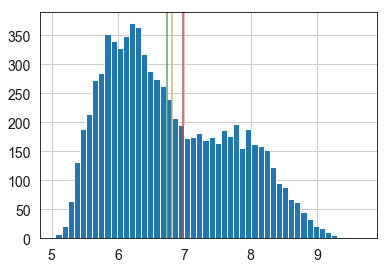

In [13]:
_ = plt.hist(s1.obs['log1p_total_counts'], bins=50)
plt.axvline(thresh_otsu, color='r') # otsu
plt.axvline(thresh_li, color='g') # li
plt.axvline(s1.obs['log1p_total_counts'][3401], color='y') # threshold chosen from one of the inflection point percentage cutoffs